# Time Series Forecasting of Temperature using LSTM
### Author: Basel Al-Dwairi

This notebook implements a Long Short-Term Memory (LSTM) network for hourly temperature forecasting using historical weather data.

Compared to a standard RNN, the LSTM architecture is designed to capture longer-term temporal dependencies and mitigate the vanishing gradient problem, making it well-suited for time series modeling.

In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-12-28 18:51:18.107973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-28 18:51:18.236621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-28 18:51:19.895732: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/tripwireguy/PycharmProjects/Jordan_2018_car_accidents_weather/.venv/lib/python3.12/si

### Library Imports

The following libraries are used for model development, training, and evaluation:

- TensorFlow / Keras: LSTM model construction and training
- Pandas & NumPy: data handling and numerical operations
- Scikit-learn: data scaling and evaluation metrics
- Matplotlib & Seaborn visualization of model performance
- Warnings suppressing non-critical future warnings


In [2]:
data_path = '../data/preprocessed_data_2010_2025.csv'

### Dataset Loading

The preprocessed weather dataset is loaded from disk.

##### This dataset includes:
- Numerical weather measurements
- Cyclically encoded wind direction
- One-hot encoded weather condition labels

All preprocessing steps are performed in a separate pipeline to ensure modularity and reproducibility.


In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,Datetime,Temperature,Wind Speed,Condition_Blowing Sand,Condition_Cloudy,Condition_Drizzle,Condition_Duststorm,Condition_Fair,Condition_Fog,Condition_Freezing Rain,...,Condition_Small Hail,Condition_Smoke,Condition_Snow,Condition_Snow Grains,Condition_Squalls,Condition_Thunder,Condition_Widespread Dust,Condition_Wintry Mix,WindDir_sin,WindDir_cos
0,2010-01-01 00:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.866025,-4.999999e-01
1,2010-01-01 01:00:00,10.000000,6.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-1.000000,1.192488e-08
2,2010-01-01 02:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
3,2010-01-01 03:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
4,2010-01-01 04:00:00,11.111111,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01


In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

### Data Loading and Temporal Ordering

The preprocessed weather dataset is loaded and converted into a datetime-indexed time series.

##### All records are:
- Sorted chronologically
- Indexed by timestamp

In [6]:
target = 'Temperature'
features = ['Temperature', 'Wind Speed', 'WindDir_sin','WindDir_cos']

### Feature Selection

##### The model uses the following features:
- Temperature : (target and autoregressive input)
- Wind Speed
- Wind Direction (sin, cos) : cyclical encoding to preserve angular continuity

##### The target variable is:
- Temperature (°C)

Including temperature as an input allows the RNN to model autoregressive temporal behavior, which is standard in time series forecasting.

In [7]:
split_date = '2022-1-1'
train_df = df.loc[:split_date]
test_df = df.loc[split_date:]

### Time-Based Train–Test Split

##### The dataset is split chronologically using a fixed cutoff date:

- Training data: up to 2022-01-01  
- Testing data: from 2022-01-01 onward

In [8]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [9]:
X_train = X_scaler.fit_transform(train_df[features])
X_test = X_scaler.transform(test_df[features])

In [10]:
y_train = y_scaler.fit_transform(train_df[[target]])
y_test = y_scaler.transform(test_df[[target]])

### Feature Scaling

##### Min–Max normalization is applied separately to:
- Input features
- Target variable

In [11]:
WINDOW = 24

In [12]:
def make_sequence(X, y, window=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])

    return np.array(X_seq), np.array(y_seq)

### Sliding Window Sequence Generation

To capture temporal dependencies, the data is transformed into fixed-length sequences using a sliding window.

##### Configuration:
- 24 hours per day
- 3 days per sequence
- Window size = 72 time steps

Each input sequence predicts the temperature at the next hour.

3 days were chosen due to technical limitations.

In [13]:
X_train_seq, y_train_seq = make_sequence(X_train, y_train, window=WINDOW)

In [14]:
X_test_seq, y_test_seq = make_sequence(X_test, y_test, window=WINDOW)

In [15]:
model = Sequential([
    Input(shape=(X_test_seq.shape[1],X_test_seq.shape[2])),
    LSTM(64,activation='tanh'),
    Dense(1, activation='linear')
])

In [16]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [18]:
model_checkpoint = ModelCheckpoint(
    '../models/lstm_best_model_full.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

### LSTM Model Architecture

The forecasting model is built using a single LSTM layer followed by a dense output layer.

##### Architecture:
- Input layer: (window length × number of features)
- LSTM layer with 64 hidden units
- Fully connected output layer

##### Activation:
- `tanh` for the LSTM layer (standard for recurrent models)
- `linear` for the output layer (Regression)

##### Loss function:
- Mean Squared Error (MSE)

##### Optimizer:
- Adam optimizer with learning rate = 0.001

In [19]:
model.fit(X_train_seq,
          y_train_seq,
         validation_split=0.1,
         epochs=25,
         batch_size=32,
         callbacks=[model_checkpoint, early_stopping])

Epoch 1/25


2025-12-28 18:51:25.444766: I external/local_xla/xla/service/service.cc:163] XLA service 0x7eb7f000a800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-28 18:51:25.444790: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-12-28 18:51:25.490093: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  29/2931 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1422 - mae: 0.3006

I0000 00:00:1766937086.469635   35942 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2931/2931 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0021 - mae: 0.0288 - val_loss: 5.4347e-04 - val_mae: 0.0174
Epoch 2/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 5.5587e-04 - mae: 0.0175 - val_loss: 6.1548e-04 - val_mae: 0.0186
Epoch 3/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 5.1768e-04 - mae: 0.0168 - val_loss: 5.0891e-04 - val_mae: 0.0167
Epoch 4/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 4.9757e-04 - mae: 0.0163 - val_loss: 4.7687e-04 - val_mae: 0.0157
Epoch 5/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 4.8612e-04 - mae: 0.0161 - val_loss: 5.2028e-04 - val_mae: 0.0170
Epoch 6/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 4.7502e-04 - mae: 0.0160 - val_loss: 4.7318e-04 - val_mae: 0.0160
Epoch 7/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 4.7018e-04 - mae: 0.0158 - val_loss: 4.6810e-04 - val_mae: 0.0156
Epoch 8/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 4.6259e-04 - mae: 0.0157 - val_loss: 4.4293e-04 -

### Training Strategy

##### To improve generalization and prevent overfitting:
- Early stopping is used based on validation loss
- Model checkpointing saves the best-performing model

##### Training details:
- Epochs: up to 25
- Batch size: 32
- Validation split: 10% of training data

In [20]:
y_pred_scaled = model.predict(X_test_seq)

1089/1089 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [21]:
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test_seq)

In [22]:
mae = mean_absolute_error(y_true,y_pred)

In [23]:
mse = mean_squared_error(y_true,y_pred)

In [24]:
r2 = r2_score(y_true,y_pred)

In [25]:
print(f'{'LSTM-Temp':-^30}')
print(f'{mae = :.5f}')
print(f'{mse = :.5f}')
print(f'{r2  = :.5f}')

----------LSTM-Temp-----------
mae = 0.68071
mse = 0.84582
r2  = 0.98731


### Model Evaluation

##### Model performance is evaluated on the unseen test set using regression metrics:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- R² Score

Predictions are inverse-transformed to the original temperature scale before evaluation.

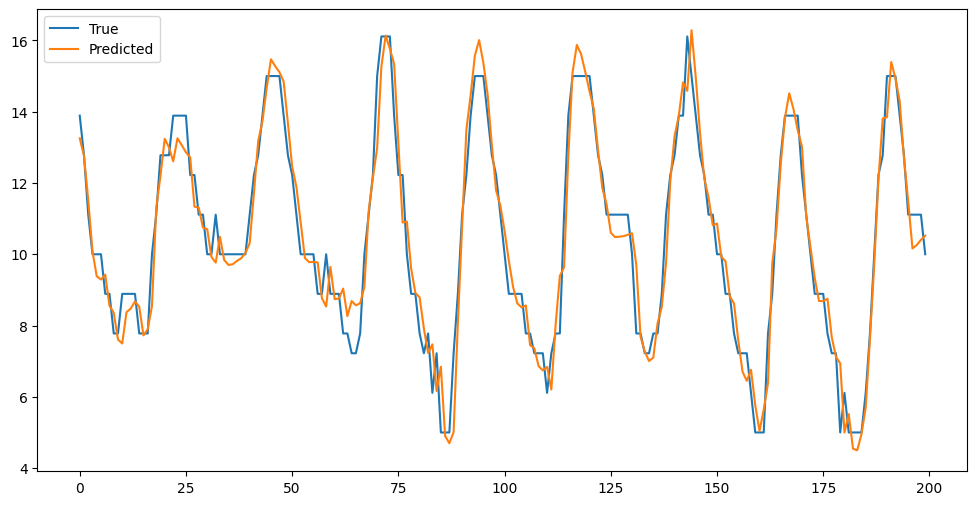

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_true[-200:], label='True')
ax.plot(y_pred[-200:], label='Predicted')
plt.legend()
plt.show()

### Prediction vs Ground Truth

the final plot compares predicted and true temperature values over the last 200 time steps of the test set, illustrating the model’s ability to follow short-term temperature trends.
